## Load-in dependencies:

In [1]:
using Pkg
# Pkg.add("Profile")
# Pkg.instantiate()

In [2]:
#= dependencies = ["DelimitedFiles", "LinearAlgebra", "Optim", "Distributions", "Test",
                "BenchmarkTools", "Random", "CSV", "DataFrames", "Distributed", "Plots"];
Pkg.add(dependencies)=#

In [3]:
using DelimitedFiles
using LinearAlgebra
using Optim
using Distributions
using Test
using BenchmarkTools
using Random
using CSV
using DataFrames
using Plots
using Profile
using Distributed

In [4]:
pwd()

"/Users/FredYu/Documents/GitHub/BulkLMM.jl/analysis"

In [5]:
## Include the source code of BulkLMM to be tested:
include("../src/scan.jl");
include("../src/lmm.jl");
include("../src/wls.jl");
include("../src/util.jl");
include("../src/kinship.jl");
include("../src/readData.jl");
include("../src/scan_for_tests.jl")
include("../src/scan_distributed.jl") # new function

## Also include the helper functions for writing tests:
include("../test/testHelper.jl");

## Read in BXD data:

In [6]:
## Read in BXD data:
pheno_file = "../data/bxdData/BXDtraits.csv"
pheno = readBXDpheno(pheno_file);
geno_file = "../data/bxdData/BXDgeno_prob.csv"
geno = readGenoProb_ExcludeComplements(geno_file);

kinship = calcKinship(geno); # calculate kinship matrix from genotype data

In [7]:
nperms = 1024; # number of permutated copies required;
m = size(pheno, 2);
p = size(geno, 2); # number of markers

In [8]:
## Consider the 7919-th trait
pheno_y = reshape(pheno[:, 7919], :, 1);

In [9]:
using StatsBase

In [10]:
n_seeds = 4;

In [11]:
seeds_list = StatsBase.sample(1:100, n_seeds; replace = false)

4-element Vector{Int64}:
 63
 81
  1
 74

## Three phases of data transformations:

In [12]:
(y0, X0, lambda0) = transform1(pheno_y, geno, kinship);

In [13]:
# unique(round.(lambda0; digits = 3))

In [14]:
(r0, X00) = transform2(y0, X0, lambda0; reml = false);

In [15]:
r0perm = transform3(r0; nperms = 400, rndseed = 0, original = false);

In [16]:
size(r0perm)

(79, 400)

## Study: distribute over permutations

### Check results:

Will the results be consistent, if we fixed the set of rotated data for further algorithm?

In [17]:
map_results = map(x -> scan_distributed(y0, X0, lambda0; nperms = 100, rndseed = x, original = false), seeds_list);
map_LODs = reduce(vcat, map_results);

In [18]:
using Distributed

In [19]:
# addprocs(4);

In [20]:
# procs()

In [21]:
# rmprocs([2, 3])

In [22]:
procs()

5-element Vector{Int64}:
 1
 2
 3
 4
 5

In [23]:
@everywhere begin
    using Random
    using LinearAlgebra
    using Optim
    using Distributed
    
    ## Include the source code of BulkLMM to be tested:
    include("../src/scan.jl");
    include("../src/lmm.jl");
    include("../src/wls.jl");
    include("../src/util.jl");
    include("../src/kinship.jl");
    include("../src/readData.jl");
    include("../src/scan_for_tests.jl")
    include("../src/scan_distributed.jl")

end

In [24]:
pmap_results = pmap(x -> scan_distributed(y0, X0, lambda0; nperms = 100, rndseed = x, original = false), seeds_list);
pmap_LODs = reduce(vcat, pmap_results);

In [25]:
size(pmap_LODs)

(400, 7321)

In [26]:
pmap_LODs[1:6, 1:6]

6×6 Matrix{Float64}:
 0.0130505  0.0130505  0.0130505  0.0130505  0.0130505  0.0130505
 0.285507   0.285507   0.285507   0.285507   0.285507   0.285507
 0.0717116  0.0717116  0.0717116  0.0717116  0.0717116  0.0717116
 0.375293   0.375293   0.375293   0.375293   0.375293   0.375293
 0.0468444  0.0468444  0.0468444  0.0468444  0.0468444  0.0468444
 0.132442   0.132442   0.132442   0.132442   0.132442   0.132442

In [27]:
map_LODs[1:6, 1:6]

6×6 Matrix{Float64}:
 0.0130505  0.0130505  0.0130505  0.0130505  0.0130505  0.0130505
 0.285507   0.285507   0.285507   0.285507   0.285507   0.285507
 0.0717116  0.0717116  0.0717116  0.0717116  0.0717116  0.0717116
 0.375293   0.375293   0.375293   0.375293   0.375293   0.375293
 0.0468444  0.0468444  0.0468444  0.0468444  0.0468444  0.0468444
 0.132442   0.132442   0.132442   0.132442   0.132442   0.132442

In [28]:
maxSqDiff(map_LODs, pmap_LODs) 

0.0

It turned out that if we give the same set of rotated data, results will match, which implies that the inconsistency of results may only be due to the rotation process (sign ambiguity in eigendecomposition).

### Benchmarking:

map(permutations)

In [29]:
@benchmark begin
    transform1(pheno_y, geno, kinship);
    map(x -> scan_distributed(y0, X0, lambda0; nperms = 100, rndseed = x, original = false), seeds_list)
end

BenchmarkTools.Trial: 2 samples with 1 evaluation.
 Range (min … max):  3.420 s …   3.443 s  ┊ GC (min … max): 18.50% … 18.60%
 Time  (median):     3.431 s              ┊ GC (median):    18.55%
 Time  (mean ± σ):   3.431 s ± 16.045 ms  ┊ GC (mean ± σ):  18.55% ±  0.07%

  █                                                       █  
  █▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁█ ▁
  3.42 s         Histogram: frequency by time        3.44 s <

 Memory estimate: 5.40 GiB, allocs estimate: 294897.

pmap(permutations)

In [30]:
@benchmark begin
    transform1(pheno_y, geno, kinship);
    pmap(x -> scan_distributed(y0, X0, lambda0; nperms = 100, rndseed = x, original = false), seeds_list)
end

BenchmarkTools.Trial: 5 samples with 1 evaluation.
 Range (min … max):  1.015 s …   1.117 s  ┊ GC (min … max): 0.00% … 0.00%
 Time  (median):     1.078 s              ┊ GC (median):    0.00%
 Time  (mean ± σ):   1.073 s ± 36.614 ms  ┊ GC (mean ± σ):  0.18% ± 0.40%

  █                                 ███                   █  
  █▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁███▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁█ ▁
  110 s          Histogram: frequency by time        1.12 s <

 Memory estimate: 31.36 MiB, allocs estimate: 549.

In [31]:
@benchmark map(x -> scan_distributed(y0, X0, lambda0; nperms = 100, rndseed = x, original = false), seeds_list)

BenchmarkTools.Trial: 2 samples with 1 evaluation.
 Range (min … max):  3.417 s …   3.480 s  ┊ GC (min … max): 18.49% … 18.51%
 Time  (median):     3.449 s              ┊ GC (median):    18.50%
 Time  (mean ± σ):   3.449 s ± 44.591 ms  ┊ GC (mean ± σ):  18.50% ±  0.02%

  █                                                       █  
  █▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁█ ▁
  3.42 s         Histogram: frequency by time        3.48 s <

 Memory estimate: 5.39 GiB, allocs estimate: 294874.

In [32]:
@benchmark pmap(x -> scan_distributed(y0, X0, lambda0; nperms = 100, rndseed = x, original = false), seeds_list)

BenchmarkTools.Trial: 5 samples with 1 evaluation.
 Range (min … max):  914.562 ms …   1.064 s  ┊ GC (min … max): 0.00% … 0.00%
 Time  (median):        1.048 s              ┊ GC (median):    0.00%
 Time  (mean ± σ):      1.023 s ± 61.312 ms  ┊ GC (mean ± σ):  0.00% ± 0.00%

  ▁                                                  ▁ █     ▁  
  █▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁█▁█▁▁▁▁▁█ ▁
  915 ms          Histogram: frequency by time           160 s <

 Memory estimate: 22.36 MiB, allocs estimate: 565.

## Study: distribute over markers

### Check results:

In [33]:
r0perm = transform3(r0; nperms = 400, rndseed = 0, original = true);

In [34]:
size(r0perm) 
# 401 permutations of a vector of length 79 (79 measurements), plus the original, for results checking with scan_null

(79, 401)

In [35]:
map_eachMarker_LODs = map(x -> scan_distributed(r0perm, X00, x), 1:7321);
map_eachMarker_LODs = reduce(vcat, map_eachMarker_LODs);

In [36]:
pmap_eachMarker_LODs = pmap(x -> scan_distributed(r0perm, X00, x), 1:7321);
pmap_eachMarker_LODs = reduce(vcat, pmap_eachMarker_LODs);

In [37]:
scan_null_original = scan(pheno_y, geno, kinship)[3]; # original trait vector LODs

In [38]:
map_eachMarker_LODs[1:6, 1:6]

6×6 Matrix{Float64}:
 0.00819636  1.71913  0.225974  0.0167808  0.0800067  0.000354535
 0.00819636  1.71913  0.225974  0.0167808  0.0800067  0.000354535
 0.00819636  1.71913  0.225974  0.0167808  0.0800067  0.000354535
 0.00819636  1.71913  0.225974  0.0167808  0.0800067  0.000354535
 0.00819636  1.71913  0.225974  0.0167808  0.0800067  0.000354535
 0.00819636  1.71913  0.225974  0.0167808  0.0800067  0.000354535

In [39]:
pmap_eachMarker_LODs[1:6, 1:6]

6×6 Matrix{Float64}:
 0.00819636  1.71913  0.225974  0.0167808  0.0800067  0.000354535
 0.00819636  1.71913  0.225974  0.0167808  0.0800067  0.000354535
 0.00819636  1.71913  0.225974  0.0167808  0.0800067  0.000354535
 0.00819636  1.71913  0.225974  0.0167808  0.0800067  0.000354535
 0.00819636  1.71913  0.225974  0.0167808  0.0800067  0.000354535
 0.00819636  1.71913  0.225974  0.0167808  0.0800067  0.000354535

In [40]:
scan_null_original[1:6]

6-element Vector{Float64}:
 0.008196360329322583
 0.008196360329322583
 0.008196360329331354
 0.008196360329331354
 0.008196360329322583
 0.008196360329322583

In [41]:
maxSqDiff(map_eachMarker_LODs, pmap_eachMarker_LODs)

7.888609052210118e-29

In [42]:
maxSqDiff(reshape(pmap_eachMarker_LODs[:, 1], :, 1), reshape(scan_null_original, :, 1))

3.155443620884047e-28

In [43]:
disLoops_LODs = scan_distributed(r0perm, X00);

In [44]:
disLoops_LODs[1:6, 1:6]

6×6 Matrix{Float64}:
 0.00819636  1.71913  0.225974  0.0167808  0.0800067  0.000354535
 0.00819636  1.71913  0.225974  0.0167808  0.0800067  0.000354535
 0.00819636  1.71913  0.225974  0.0167808  0.0800067  0.000354535
 0.00819636  1.71913  0.225974  0.0167808  0.0800067  0.000354535
 0.00819636  1.71913  0.225974  0.0167808  0.0800067  0.000354535
 0.00819636  1.71913  0.225974  0.0167808  0.0800067  0.000354535

In [45]:
pmap_eachMarker_LODs[1:6, 1:6]

6×6 Matrix{Float64}:
 0.00819636  1.71913  0.225974  0.0167808  0.0800067  0.000354535
 0.00819636  1.71913  0.225974  0.0167808  0.0800067  0.000354535
 0.00819636  1.71913  0.225974  0.0167808  0.0800067  0.000354535
 0.00819636  1.71913  0.225974  0.0167808  0.0800067  0.000354535
 0.00819636  1.71913  0.225974  0.0167808  0.0800067  0.000354535
 0.00819636  1.71913  0.225974  0.0167808  0.0800067  0.000354535

In [46]:
permutedims(scan_perms2(pheno_y, geno, kinship; nperms = 400, rndseed = 0, original = true))[1:6, 1:6]

6×6 Matrix{Float64}:
 0.00819636  1.71913  0.225974  0.0167808  0.0800067  0.000354535
 0.00819636  1.71913  0.225974  0.0167808  0.0800067  0.000354535
 0.00819636  1.71913  0.225974  0.0167808  0.0800067  0.000354535
 0.00819636  1.71913  0.225974  0.0167808  0.0800067  0.000354535
 0.00819636  1.71913  0.225974  0.0167808  0.0800067  0.000354535
 0.00819636  1.71913  0.225974  0.0167808  0.0800067  0.000354535

### Benchmarking:

In [47]:
@benchmark map(x -> scan_distributed(r0perm, X00, x), 1:7321)

BenchmarkTools.Trial: 2 samples with 1 evaluation.
 Range (min … max):  3.058 s …   3.102 s  ┊ GC (min … max): 14.40% … 15.41%
 Time  (median):     3.080 s              ┊ GC (median):    14.91%
 Time  (mean ± σ):   3.080 s ± 30.927 ms  ┊ GC (mean ± σ):  14.91% ±  0.71%

  █                                                       █  
  █▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁█ ▁
  360 s          Histogram: frequency by time         3.1 s <

 Memory estimate: 5.33 GiB, allocs estimate: 109817.

In [48]:
@benchmark pmap(x -> scan_distributed(r0perm, X00, x), 1:7321)

BenchmarkTools.Trial: 1 sample with 1 evaluation.
 Single result which took 11.191 s (0.00% GC) to evaluate,
 with a memory estimate of 45.25 MiB, over 506817 allocations.

In [49]:
@benchmark scan_distributed(r0perm, X00) # using distributed loops for each marker

BenchmarkTools.Trial: 2 samples with 1 evaluation.
 Range (min … max):  4.635 s …   4.703 s  ┊ GC (min … max): 0.00% … 0.18%
 Time  (median):     4.669 s              ┊ GC (median):    0.09%
 Time  (mean ± σ):   4.669 s ± 47.973 ms  ┊ GC (mean ± σ):  0.09% ± 0.13%

  █                                                       █  
  █▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁█ ▁
  4.64 s         Histogram: frequency by time         4.7 s <

 Memory estimate: 117.63 MiB, allocs estimate: 1305.

In [50]:
 # using ordinary loops for each marker
@benchmark scan_perms2(pheno_y, geno, kinship; nperms = 400, original = true, rndseed = 0)

BenchmarkTools.Trial: 2 samples with 1 evaluation.
 Range (min … max):  3.181 s …   3.264 s  ┊ GC (min … max): 16.02% … 15.78%
 Time  (median):     3.222 s              ┊ GC (median):    15.90%
 Time  (mean ± σ):   3.222 s ± 58.259 ms  ┊ GC (mean ± σ):  15.90% ±  0.17%

  █                                                       █  
  █▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁█ ▁
  3.18 s         Histogram: frequency by time        3.26 s <

 Memory estimate: 5.34 GiB, allocs estimate: 116439.

In [51]:
range = 1:6;
typeof(range)

UnitRange{Int64}

## Study: distribute over blocks of markers

### Check results:

In [52]:
permutedims(scan_distributed_block(r0perm, X00, 1:6))[1:6, 1:6]

6×6 Matrix{Float64}:
 0.00819636  1.71913  0.225974  0.0167808  0.0800067  0.000354535
 0.00819636  1.71913  0.225974  0.0167808  0.0800067  0.000354535
 0.00819636  1.71913  0.225974  0.0167808  0.0800067  0.000354535
 0.00819636  1.71913  0.225974  0.0167808  0.0800067  0.000354535
 0.00819636  1.71913  0.225974  0.0167808  0.0800067  0.000354535
 0.00819636  1.71913  0.225974  0.0167808  0.0800067  0.000354535

In [53]:
pmap_eachMarker_LODs[1:6, 1:6]

6×6 Matrix{Float64}:
 0.00819636  1.71913  0.225974  0.0167808  0.0800067  0.000354535
 0.00819636  1.71913  0.225974  0.0167808  0.0800067  0.000354535
 0.00819636  1.71913  0.225974  0.0167808  0.0800067  0.000354535
 0.00819636  1.71913  0.225974  0.0167808  0.0800067  0.000354535
 0.00819636  1.71913  0.225974  0.0167808  0.0800067  0.000354535
 0.00819636  1.71913  0.225974  0.0167808  0.0800067  0.000354535

In [54]:
## https://stackoverflow.com/questions/26953340/partition-equivalent-in-julia

function partition_array_indices(nb_data::Int, nb_data_per_chunk::Int)
    nb_chunks = ceil(Int, nb_data / nb_data_per_chunk)
    ids = UnitRange{Int}[]
    for which_chunk = 1:nb_chunks
        id_start::Int = 1 + nb_data_per_chunk * (which_chunk - 1)
        id_end::Int = id_start - 1 + nb_data_per_chunk
        if id_end > nb_data
            id_end = nb_data
        end
        push!(ids, id_start:id_end)
    end
    return ids
end

partition_array_indices (generic function with 1 method)

In [55]:
blocks_partitions = partition_array_indices(p, 1000)

8-element Vector{UnitRange{Int64}}:
 1:1000
 1001:2000
 2001:3000
 3001:4000
 4001:5000
 5001:6000
 6001:7000
 7001:7321

In [56]:
map_blocks_LODs = map(x -> scan_distributed_block(r0perm, X00, x), blocks_partitions);
map_blocks_LODs = permutedims(reduce(hcat, map_blocks_LODs));

In [57]:
map_blocks_LODs[1:6, 1:6]

6×6 Matrix{Float64}:
 0.00819636  1.71913  0.225974  0.0167808  0.0800067  0.000354535
 0.00819636  1.71913  0.225974  0.0167808  0.0800067  0.000354535
 0.00819636  1.71913  0.225974  0.0167808  0.0800067  0.000354535
 0.00819636  1.71913  0.225974  0.0167808  0.0800067  0.000354535
 0.00819636  1.71913  0.225974  0.0167808  0.0800067  0.000354535
 0.00819636  1.71913  0.225974  0.0167808  0.0800067  0.000354535

In [58]:
pmap_blocks_LODs = pmap(x -> scan_distributed_block(r0perm, X00, x), blocks_partitions);
pmap_blocks_LODs = permutedims(reduce(hcat, pmap_blocks_LODs));

In [59]:
pmap_blocks_LODs[1:6, 1:6]

6×6 Matrix{Float64}:
 0.00819636  1.71913  0.225974  0.0167808  0.0800067  0.000354535
 0.00819636  1.71913  0.225974  0.0167808  0.0800067  0.000354535
 0.00819636  1.71913  0.225974  0.0167808  0.0800067  0.000354535
 0.00819636  1.71913  0.225974  0.0167808  0.0800067  0.000354535
 0.00819636  1.71913  0.225974  0.0167808  0.0800067  0.000354535
 0.00819636  1.71913  0.225974  0.0167808  0.0800067  0.000354535

In [60]:
normal_LODs = scan_perms2(pheno_y, geno, kinship; nperms = 400, rndseed = 0, original = true);
normal_LODs = permutedims(normal_LODs);

In [61]:
normal_LODs[1:6, 1:6]

6×6 Matrix{Float64}:
 0.00819636  1.71913  0.225974  0.0167808  0.0800067  0.000354535
 0.00819636  1.71913  0.225974  0.0167808  0.0800067  0.000354535
 0.00819636  1.71913  0.225974  0.0167808  0.0800067  0.000354535
 0.00819636  1.71913  0.225974  0.0167808  0.0800067  0.000354535
 0.00819636  1.71913  0.225974  0.0167808  0.0800067  0.000354535
 0.00819636  1.71913  0.225974  0.0167808  0.0800067  0.000354535

In [62]:
maxSqDiff(pmap_blocks_LODs, normal_LODs)

7.888609052210118e-29

### Benchmarking:

In [63]:
blocks_partitions

8-element Vector{UnitRange{Int64}}:
 1:1000
 1001:2000
 2001:3000
 3001:4000
 4001:5000
 5001:6000
 6001:7000
 7001:7321

In [64]:
@benchmark map(x -> scan_distributed_block(r0perm, X00, x), blocks_partitions)

BenchmarkTools.Trial: 2 samples with 1 evaluation.
 Range (min … max):  3.324 s …   3.391 s  ┊ GC (min … max): 16.55% … 16.72%
 Time  (median):     3.357 s              ┊ GC (median):    16.64%
 Time  (mean ± σ):   3.357 s ± 46.925 ms  ┊ GC (mean ± σ):  16.64% ±  0.12%

  █                                                       █  
  █▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁█ ▁
  3.32 s         Histogram: frequency by time        3.39 s <

 Memory estimate: 5.32 GiB, allocs estimate: 73284.

In [65]:
@benchmark pmap(x -> scan_distributed_block(r0perm, X00, x), blocks_partitions)

BenchmarkTools.Trial: 5 samples with 1 evaluation.
 Range (min … max):  938.110 ms …   1.088 s  ┊ GC (min … max): 0.00% … 0.00%
 Time  (median):        1.044 s              ┊ GC (median):    0.00%
 Time  (mean ± σ):      1.029 s ± 62.306 ms  ┊ GC (mean ± σ):  0.00% ± 0.00%

  █                      █                  █             █  █  
  █▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁█▁▁▁▁▁▁▁▁▁▁▁▁▁█▁▁█ ▁
  938 ms          Histogram: frequency by time           190 s <

 Memory estimate: 22.43 MiB, allocs estimate: 930.

In [66]:
@benchmark begin 
    transform1(pheno_y, geno, kinship);
    transform2(y0, X0, lambda0);
    pmap(x -> scan_distributed_block(r0perm, X00, x), blocks_partitions);
end

BenchmarkTools.Trial: 6 samples with 1 evaluation.
 Range (min … max):  943.908 ms …   1.113 s  ┊ GC (min … max): 0.00% … 2.13%
 Time  (median):     955.054 ms              ┊ GC (median):    0.00%
 Time  (mean ± σ):   982.581 ms ± 65.391 ms  ┊ GC (mean ± σ):  0.40% ± 0.87%

  █  ▁▁        ▁                                             ▁  
  █▁▁██▁▁▁▁▁▁▁▁█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁█ ▁
  944 ms          Histogram: frequency by time          1.11 s <

 Memory estimate: 49.35 MiB, allocs estimate: 1367.

In [67]:
@benchmark scan_perms2(pheno_y, geno, kinship; nperms = 400, rndseed = 0, original = true)

BenchmarkTools.Trial: 2 samples with 1 evaluation.
 Range (min … max):  3.205 s …   3.225 s  ┊ GC (min … max): 16.22% … 16.41%
 Time  (median):     3.215 s              ┊ GC (median):    16.32%
 Time  (mean ± σ):   3.215 s ± 14.648 ms  ┊ GC (mean ± σ):  16.32% ±  0.13%

  █                                                       █  
  █▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁█ ▁
  3.2 s          Histogram: frequency by time        3.23 s <

 Memory estimate: 5.34 GiB, allocs estimate: 116439.

In [68]:
@benchmark pmap(x -> scan_distributed(y0, X0, lambda0; nperms = 100, rndseed = x, original = false), seeds_list)

BenchmarkTools.Trial: 5 samples with 1 evaluation.
 Range (min … max):  967.740 ms …    1.344 s  ┊ GC (min … max): 0.00% … 0.00%
 Time  (median):        1.112 s               ┊ GC (median):    0.00%
 Time  (mean ± σ):      1.106 s ± 151.286 ms  ┊ GC (mean ± σ):  0.00% ± 0.00%

  █ █                    █ █                                  █  
  █▁█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁█▁█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁█ ▁
  968 ms           Histogram: frequency by time          1.34 s <

 Memory estimate: 22.36 MiB, allocs estimate: 568.

## Compare times for different choices of nperms and block sizes:

In [69]:
@everywhere nperms_list = [50, 80, 100, 200, 400];
@everywhere bsizes_list = [100, 300, 500, 600, 1000];

In [70]:
runtimes_nperms = Array{Float64, 1}(undef, length(nperms_list));
runtimes_bsizes = Array{Float64, 1}(undef, length(bsizes_list));

In [71]:
procs() # check number of procs active rn

5-element Vector{Int64}:
 1
 2
 3
 4
 5

In [72]:
blocks_partitions = partition_array_indices(p, 500)

15-element Vector{UnitRange{Int64}}:
 1:500
 501:1000
 1001:1500
 1501:2000
 2001:2500
 2501:3000
 3001:3500
 3501:4000
 4001:4500
 4501:5000
 5001:5500
 5501:6000
 6001:6500
 6501:7000
 7001:7321

In [97]:
size(r0perm)

(79, 401)

In [73]:
@benchmark pmap(x -> scan_distributed_block(r0perm, X00, x), blocks_partitions)

BenchmarkTools.Trial: 6 samples with 1 evaluation.
 Range (min … max):  931.019 ms …   1.016 s  ┊ GC (min … max): 0.00% … 0.00%
 Time  (median):     970.293 ms              ┊ GC (median):    0.00%
 Time  (mean ± σ):   972.562 ms ± 33.542 ms  ┊ GC (mean ± σ):  0.00% ± 0.00%

  █        █          █              █               █       █  
  █▁▁▁▁▁▁▁▁█▁▁▁▁▁▁▁▁▁▁█▁▁▁▁▁▁▁▁▁▁▁▁▁▁█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁█▁▁▁▁▁▁▁█ ▁
  931 ms          Histogram: frequency by time           120 s <

 Memory estimate: 22.46 MiB, allocs estimate: 1544.

In [74]:
for i in 1:length(nperms_list)
    
    np = nperms_list[i];
    nseeds = Int(400/np);
    
    seeds_list = StatsBase.sample(1:100, nseeds; replace = false)
    b = @benchmark pmap(x -> scan_distributed(y0, X0, lambda0; nperms = $np, rndseed = x, original = false), seeds_list);
    b = median(b)
    
    runtimes_nperms[i] = time(b)/1e9
    
end

In [98]:
for i in 1:length(bsizes_list)
    
    bs = bsizes_list[i];
    
    blocks_partitions = partition_array_indices(p, bs);

    
    b = @benchmark pmap(x -> scan_distributed_block(r0perm, X00, x), blocks_partitions);
    b = median(b)
    
    runtimes_bsizes[i] = time(b)/1e9
    
end

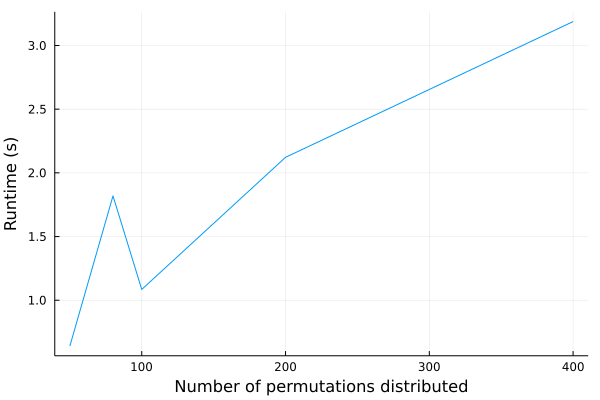

In [108]:
plot(nperms_list, runtimes_nperms; xlabel= "Number of permutations distributed", ylabel = "Runtime (s)", legend = false)

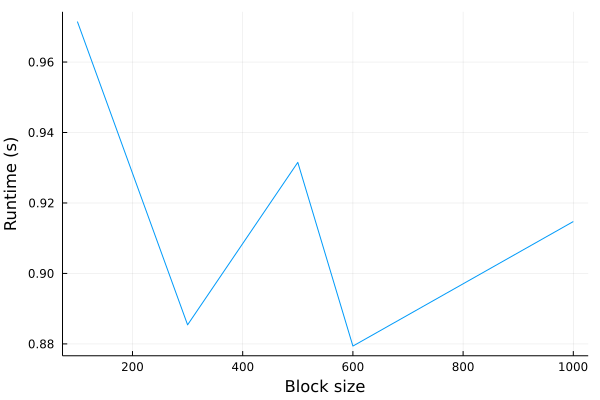

In [109]:
plot(bsizes_list, runtimes_bsizes; xlabel= "Block size", ylabel = "Runtime (s)", legend = false)

In [110]:
blocks_partitions = partition_array_indices(p, 600)

13-element Vector{UnitRange{Int64}}:
 1:600
 601:1200
 1201:1800
 1801:2400
 2401:3000
 3001:3600
 3601:4200
 4201:4800
 4801:5400
 5401:6000
 6001:6600
 6601:7200
 7201:7321

In [111]:
@benchmark pmap(x -> scan_distributed_block(r0perm, X00, x), blocks_partitions)

BenchmarkTools.Trial: 6 samples with 1 evaluation.
 Range (min … max):  876.530 ms … 933.049 ms  ┊ GC (min … max): 0.00% … 0.00%
 Time  (median):     893.107 ms               ┊ GC (median):    0.00%
 Time  (mean ± σ):   900.469 ms ±  23.321 ms  ┊ GC (mean ± σ):  0.00% ± 0.00%

  █    █          █  █                                █       █  
  █▁▁▁▁█▁▁▁▁▁▁▁▁▁▁█▁▁█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁█▁▁▁▁▁▁▁█ ▁
  877 ms           Histogram: frequency by time          933 ms <

 Memory estimate: 22.45 MiB, allocs estimate: 1397.

In [78]:
Int(400/50)

8

In [79]:
?sample

search: sample sampler sample! samplepair Sampleable wsample nsamples wsample!



```
sample([rng], a, [wv::AbstractWeights])
```

Select a single random element of `a`. Sampling probabilities are proportional to the weights given in `wv`, if provided.

Optionally specify a random number generator `rng` as the first argument (defaults to `Random.GLOBAL_RNG`).

---

```
sample([rng], a, [wv::AbstractWeights], n::Integer; replace=true, ordered=false)
```

Select a random, optionally weighted sample of size `n` from an array `a` using a polyalgorithm. Sampling probabilities are proportional to the weights given in `wv`, if provided. `replace` dictates whether sampling is performed with replacement. `ordered` dictates whether an ordered sample (also called a sequential sample, i.e. a sample where items appear in the same order as in `a`) should be taken.

Optionally specify a random number generator `rng` as the first argument (defaults to `Random.GLOBAL_RNG`).

---

```
sample([rng], a, [wv::AbstractWeights], dims::Dims; replace=true, ordered=false)
```

Select a random, optionally weighted sample from an array `a` specifying the dimensions `dims` of the output array. Sampling probabilities are proportional to the weights given in `wv`, if provided. `replace` dictates whether sampling is performed with replacement. `ordered` dictates whether an ordered sample (also called a sequential sample, i.e. a sample where items appear in the same order as in `a`) should be taken.

Optionally specify a random number generator `rng` as the first argument (defaults to `Random.GLOBAL_RNG`).

---

```
sample([rng], wv::AbstractWeights)
```

Select a single random integer in `1:length(wv)` with probabilities proportional to the weights given in `wv`.

Optionally specify a random number generator `rng` as the first argument (defaults to `Random.GLOBAL_RNG`).


## Miscellaneous:

In [80]:
n = size(y0, 1)

79

In [81]:
Loops_y0 = Array{Float64, 2}(undef, n, 10);

In [82]:
for i = 1:10
    Loops_y0[:, i] = rotateData(pheno_y, geno, kinship)[1]
end

first_col = Loops_y0[:, 1];

In [83]:
test_list = mapslices(x -> x .- first_col, Loops_y0; dims = 1);

In [84]:
test_list

79×10 Matrix{Float64}:
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 ⋮                        ⋮                   
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0 

In [85]:
# addprocs(7);
procs()

5-element Vector{Int64}:
 1
 2
 3
 4
 5

In [86]:
@everywhere begin
    using Random
    using LinearAlgebra
    using Optim
    using DelimitedFiles
    
    ## Include the source code of BulkLMM to be tested:
    include("../src/scan.jl");
    include("../src/lmm.jl");
    include("../src/wls.jl");
    include("../src/util.jl");
    include("../src/kinship.jl");
    include("../src/readData.jl");
    include("../src/scan_for_tests.jl")
    include("../src/scan_distributed.jl")

end

In [87]:
@everywhere begin 
    pheno_file = "../data/bxdData/BXDtraits.csv"
    pheno = readBXDpheno(pheno_file);
    geno_file = "../data/bxdData/BXDgeno_prob.csv"
    geno = readGenoProb_ExcludeComplements(geno_file);

    kinship = calcKinship(geno); # calculate kinship matrix from genotype data
end

In [88]:
procs()

5-element Vector{Int64}:
 1
 2
 3
 4
 5

In [89]:
# rmprocs([2, 3, 4, 5, 6, 7, 8, 9, 10])

In [90]:
disLoops_y0 = @distributed (hcat) for i = 1:10
    rotateData(pheno_y, geno, kinship)[1]
end

first_dis_col = disLoops_y0[:, 1];


In [91]:
test_dis_list = mapslices(x -> x .- first_dis_col, disLoops_y0; dims = 1);
test_dis_list

79×10 Matrix{Float64}:
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 ⋮                        ⋮                   
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0 

In [92]:
pmaps_y0

LoadError: UndefVarError: pmaps_y0 not defined

In [93]:
Loops_y0[1:15, 1:6]

15×6 Matrix{Float64}:
 -0.154545     -0.154545     -0.154545     …  -0.154545     -0.154545
 -0.535436     -0.535436     -0.535436        -0.535436     -0.535436
  0.533096      0.533096      0.533096         0.533096      0.533096
 -0.369575     -0.369575     -0.369575        -0.369575     -0.369575
  0.593334      0.593334      0.593334         0.593334      0.593334
  0.158392      0.158392      0.158392     …   0.158392      0.158392
  0.185084      0.185084      0.185084         0.185084      0.185084
 -0.0298419    -0.0298419    -0.0298419       -0.0298419    -0.0298419
 -0.340062     -0.340062     -0.340062        -0.340062     -0.340062
 -0.348007     -0.348007     -0.348007        -0.348007     -0.348007
  0.000307749   0.000307749   0.000307749  …   0.000307749   0.000307749
  0.101604      0.101604      0.101604         0.101604      0.101604
 -0.0267104    -0.0267104    -0.0267104       -0.0267104    -0.0267104
  0.236609      0.236609      0.236609         0.236609      0.

In [94]:
disLoops_y0[1:15, 1:6]

15×6 Matrix{Float64}:
 -0.154545     -0.154545     -0.154545     …  -0.154545     -0.154545
 -0.535436     -0.535436     -0.535436        -0.535436     -0.535436
 -0.533096     -0.533096     -0.533096        -0.533096     -0.533096
 -0.369575     -0.369575     -0.369575        -0.369575     -0.369575
  0.593334      0.593334      0.593334         0.593334      0.593334
  0.158392      0.158392      0.158392     …   0.158392      0.158392
 -0.185084     -0.185084     -0.185084        -0.185084     -0.185084
  0.0298419     0.0298419     0.0298419        0.0298419     0.0298419
 -0.340062     -0.340062     -0.340062        -0.340062     -0.340062
 -0.348007     -0.348007     -0.348007        -0.348007     -0.348007
  0.000307749   0.000307749   0.000307749  …   0.000307749   0.000307749
  0.101604      0.101604      0.101604         0.101604      0.101604
  0.0267104     0.0267104     0.0267104        0.0267104     0.0267104
 -0.236609     -0.236609     -0.236609        -0.236609     -0.

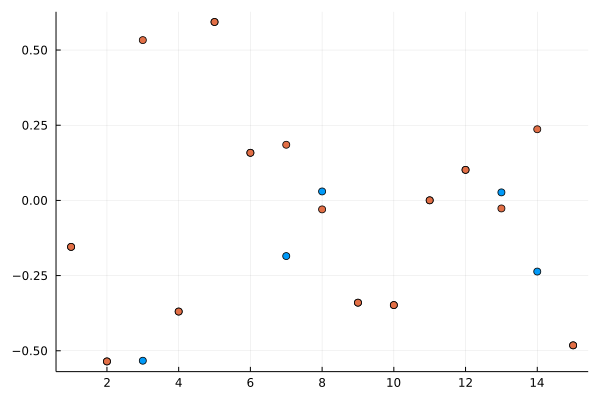

In [95]:
scatter(disLoops_y0[1:15, 1])
scatter!(Loops_y0[1:15, 1]; legend = false)

In [96]:
function getMaxLod(results::Array{Float64, 2})
    
    return mapslices(x -> maximum(x), results; dims = 2);
    
end

getMaxLod (generic function with 1 method)